# Organization of notebook

1. Imports<br>
2. Semi-analytic ($M_{crit}$ business) _functions only_<br>
    a. all functions -- serve to determine "analytic" limits<br>
3. Numerical (CLASS-based) _functions only_<br>
    a. make_inis -- makes ini files for given mass, power, etc.<br>
    b. calculate_kcuts, fit_fun, sigma0 limits -- used for getting numerical upper lims on sigma0<br>
    c. findLocalMins, findLocalMaxs -- give peaks/troughs of Tk<br>
    d. tk -- gives transfer function<br>
    e. peaks -- gets locations/amplitudes peaks of oscillatory business<br>
4. Analysis (limits)<br>
    a. Semi-analytic limits<br>
    b. Sanity check on analytics using CLASS<br>
    c. Limits via exclusion curves<br>
    d. Semi-analytic, conservative, CMB limits<br>
    e. Tables of limit values for each n<br>
5. Analysis (tk/DAOs)<br>
    f. Tk for single sigma<br>
    g. Tks for full sigma range<br>
    h. First peak amplitude<br>
    i. Peaks for same cross section<br>
    j. First, second, third peaks<br>
    k. Ratio of first to second peaks<br>

---

---

---

# Sources/Derivations

#### Various constants

http://pdg.lbl.gov/2014/reviews/rpp2014-rev-astrophysical-constants.pdf

https://arxiv.org/pdf/1904.10000

https://arxiv.org/pdf/1502.01589.pdf

#### Relevant functions

https://arxiv.org/pdf/1801.08609.pdf

$ N_0 =  2^{(5+n)/2}\Gamma(3+n/2)/(3\sqrt{\pi})$

http://sro.sussex.ac.uk/id/eprint/46339/1/MNRAS-2012-Schneider-684-98.pdf

$M_{hm} = \frac{4\pi\bar{\rho}}{3}\big(\frac{\lambda_{hm}}{2}\big)^3$

$\qquad = \frac{4\pi\bar{\rho}}{3}\big(\frac{\pi}{hk_{hm}}\big)^3$

$\therefore k_{hm} = \frac{\pi}{h}\big(\frac{4\pi\bar{\rho}}{3M_{hm}}\big)^{1/3}$

https://arxiv.org/pdf/1808.00001.pdf

$Rx_noZ = \frac{N_0a\rho_bY_p\sigma_0}{m_{\chi}+m_p}\Big(\frac{T_0}{m_p}+\frac{T_{0}}{m_{\chi}}\Big)^{\frac{1+n}{2}}$


https://arxiv.org/pdf/1904.10000

$aH = R_{\chi}(m_{\chi}/(m_{\chi}+m_p))$

Note that $aH \sim z$ and $R_{\chi} \sim z^{n+5/2}$ such that

$zH_0\sqrt{\Omega_{rad}} = R_{\chi}(m_{\chi}/(m_{\chi}+m_p))z^{n+5/2}$

$\therefore z = ((m_{\chi}+m_p)H_0\sqrt{\Omega_{rad}}/R_{\chi}m_{\chi})^{2/n+3}$

https://arxiv.org/pdf/1904.10000

$aH = R_{\chi} = \frac{N_0a\rho_bY_p\sigma_0}{m_{\chi}+m_p}\Big(\frac{T_b}{m_p}+\frac{T_{\chi}}{m_{\chi}}\Big)^{\frac{1+n}{2}}$

Note that $aH \sim z$, $a\bar{\rho} \sim z^2$, $T_b \sim z$ and $T_{\chi} \sim z^2/z_{th}$, such that

$\frac{H_0\sqrt{\Omega_{rad}}(m_{\chi}+m_p)}{N_0Y_p\rho_b\sigma_0} = z^2/z \big(\frac{T_0z}{m_p}+\frac{T_0z^2}{z_{th}m_{\chi}}\big)^{n+1/2}$

$0 = z \big(\frac{T_0z}{m_p}+\frac{T_0z^2}{z_{th}m_{\chi}}\big)^{n+1/2} - \frac{H_0\sqrt{\Omega_{rad}}(m_{\chi}+m_p)}{N_0Y_p\rho_b\sigma_0}$

Solving the above for $z$ yields $z_{kin}$

https://arxiv.org/pdf/1904.10000

$k_{crit} = aH = H_0\sqrt{\Omega_{rad}}z_{kin}^2/z_{kin} = H_0\sqrt{\Omega_{rad}}z_{kin}$

https://arxiv.org/pdf/1808.00001.pdf

$R_{x,kin} = \frac{N_0a\rho_bY_p\sigma_0}{m_{\chi}+m_p}\Big(\frac{T_0z_{th}}{m_p}+\frac{T_0z^2}{z_{th}m_{\chi}}\Big)^{\frac{1+n}{2}}$

https://arxiv.org/pdf/1808.00001.pdf

$R_{x,th} = \frac{N_0a\rho_bY_p\sigma_0}{m_{\chi}+m_p}\Big(\frac{T_0(1+z_{th})}{m_p}+\frac{T_0(1+z_{th})}{m_{\chi}}\Big)^{\frac{1+n}{2}}$

---

---

---

# Relevant imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.signal import argrelextrema
import math
import numpy as np
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import sys
import os,glob
import yaml
from chainconsumer import ChainConsumer
from scipy.special import gamma
from scipy.optimize import fsolve
from scipy.interpolate import interp1d  
import pandas as pd
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['font.family']='stix'
plt.rcParams['text.usetex']=True
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150

---

---

---

In [121]:
class VDS0():  

############################# INITIALIZATION #############################
    
    def __init__(self, h = 0.6727, Omega_m = 0.26495, Omega_b = 0.05, Omega_rad = 10e-5, p_crit = 4.755e-6,
                 rho_crit = 4.755e-6, T0 = 2.7255, kb = 8.617333262145e-5, m_p = 0.93827231, nu = 1.12,
                 Y_p = 0.75, cc = 3e5, Mpc2cm = 3.086e24, masses = np.array([1e-4,1e-3,1e-2,1e-1,1.,10.]), 
                 sigma_array = np.logspace(-10,-30,200)):
        
        self.h = h
        self.H0 = 100*h
        self.Omega_m = Omega_m
        self.Omega_b = Omega_b
        self.Omega_rad = Omega_rad
        self.Y_p = Y_p
        self.m_p = m_p
        self.nu = nu
        self.rho_crit = 1.256*10**11*Omega_m
        self.rho_b = Omega_b*p_crit
        self.T_0 = kb*T0*1e-9
        self.Rx_conerverionFactor = cc*Mpc2cm
        
        self.masses = masses
        self.sigma_array = sigma_array
            
############################# SEMI-ANALYTIC FUNCTIONS #############################
    
    def N_0(self,n):
        return pow(2,(5.+n)/2.)*gamma(3.+n/2.)/(3.*np.sqrt(np.pi))

    def mhm2khm(self,Mhm):
        return np.pi/self.h*(((4.*np.pi*self.rho_crit)/(3*Mhm))**(1./3.))
    
    def Rx_noZ(self,sigma_0, m_x, n):
        return self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow((self.T_0/m_x)+(self.T_0/self.m_p),((1.+n)/2.)))
    
    def z_th(self,sigma_0,m_x,n):
        return ((self.H0*np.sqrt(self.Omega_rad)*(m_x+self.m_p))/(self.Rx_noZ(sigma_0,m_x,n)*m_x))**(2./(n+3.))

    def z_kin(self,sigma_0,m_x,n):
        return fsolve(lambda z: z * ((self.T_0*z**2)/(self.z_th(sigma_0,m_x,n)*m_x) + (self.T_0*self.z_th(sigma_0,m_x,n))/self.m_p)**((n+1.)/2.) - (self.H0*np.sqrt(self.Omega_rad)/(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor))*(m_x+self.m_p)/sigma_0,self.z_th(sigma_0,m_x,n)/2.)    

    def sigma2k(self,sigma_0,m_x,n):
        return 2.*(self.H0*np.sqrt(self.Omega_rad)*self.z_kin(sigma_0,m_x,n))*3.33e-6

    def sigma2k2(self,sigma_0,m_x,n):
        return (self.H0*np.sqrt(self.Omega_rad)*self.z_th(sigma_0,m_x,n))*3.33e-6
    
    def Rx_kin(self,sigma_0, m_x, n):
        return self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow((self.T_0*pow(self.z_kin(sigma_0,m_x,n),2))/(m_x*self.z_th(sigma_0,m_x,n))+((self.T_0*self.z_th(sigma_0,m_x,n))/self.m_p),((1.+n)/2.)))

    def Rx_th(self,sigma_0, m_x, n):
        return self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow(((self.T_0*(1+self.z_th(sigma_0,m_x,n)))/(m_x))+((self.T_0*(1+self.z_th(sigma_0,m_x,n)))/self.m_p),((1.+n)/2.)))
    
    def sig(self,klimit,n):
        sigma = []
        for i in range(len(self.masses)):
            sigma.append(self.sigma_array[np.argmin(np.abs(self.sigma2k(self.sigma_array,self.masses[i],n)-self.h*klimit))])
        return np.array(sigma)

    def sigma_vs_mx(self,klimit,n):
        return hv.Curve((masses, self.sig(klimit,n)))
    
############################# INI GENERATION #############################

    def make_inis(self,ini_base_file='class/inis/dmeff_base.ini',base_inis_path='class/inis/',class_runner_path = 'class/',npow=0,
                  masses=np.array([1e-4,1e-3,1e-2,1e-1,1.,10.]),sigmas=np.logspace(-20,-30,100),output_path='pk_output',
                  sh_file='class/run_classes.sh'):
    
        fin =  open(ini_base_file, 'r')
        base_content = fin.read()
        fin.close()
        fout_sh = open(class_runner_path+'run_classes.sh', 'w')

        for m in masses:
            for sigma in sigmas:
                filename = 'n{}_m{}_s{}.ini'.format(npow,m,sigma)
                fout_sh.write('./class ' + 'inis/{}\n'.format(filename))
                fout = open(base_inis_path + filename, 'w')
                fout.write(base_content)
                fout.write('\n')
                npow_line = 'npow_dmeff = {}\n'.format(npow)
                fout.write(npow_line)
                m_line = 'm_dmeff = {}\n'.format(m)
                fout.write(m_line)
                sigma_line = 'sigma_dmeff = {}\n'.format(sigma)
                fout.write(sigma_line)
                if npow<0:
                    vel_line = 'Vrel_dmeff_rate = 30\n' #sets to DBK case.
                    fout.write(vel_line)
                root_line = 'root = {}/n{}_m{}_s{}_\n'.format(output_path,npow,m,sigma)
                fout.write(root_line)

        fout_sh.close()

############################# TK PLOTTING FUNCTIONS #############################
        
    def single_tk(self,npow=0,m=0.0001,plotPeaks=False,pltType='none',
              index=0,sigmas=np.logspace(-20,-30,100),lw=2.5,label='',colr='none'):

        data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        for i,sigma in enumerate(sigmas):
            # Index of interest
            if i!=index:
                continue
            sig=sigma
            print sigma
            # pk data from class for given mass, sigma, power
            filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)
            np.loadtxt(filename)
            data = np.loadtxt(filename)
            pk = data[:,1]

            if pltType=='cons':
                clr = '#D81B60'
                lbl = "$\sigma_{0,c}=$"+str(' {:.1e}'.format(float(sigma)))+" cm$^2$"
            elif pltType=='analytic':
                clr = '#63acbe'
                lbl = "$\sigma_{0,a}=$"+str(' {:.1e}'.format(float(sigma)))+" cm$^2$"
            else:
                clr = (math.sqrt((i+1.))/10,1-math.sqrt((i+1.))/10,1-math.sqrt((i+1.))/10)
                lbl = "$\sigma_0=$"+str(' {:.1e}'.format(float(sigma)))+" cm$^2$"
            plt.plot(ks,(pk)/pk0,linewidth=lw,linestyle='-',color=colr,label=label)
        return (pk)/pk0,ks,sig
    
    def all_tk(self,npow=0,m=0.0001,sigmas=np.logspace(-20,-30,100),
               z='z1',colorbar=False,pk_root='class/pk_output/',
               filename=None,label='',lw=0.3):
    
        data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        colors = [(math.sqrt((90.+1.))/10,1-math.sqrt((90.+1.))/10,1-math.sqrt((90.+1.))/10),(math.sqrt((1.))/10,1-math.sqrt((1.))/10,1-math.sqrt((1.))/10)]  # R -> G -> B
        n_bins = [100]  # Discretizes the interpolation into bins
        cm = LinearSegmentedColormap.from_list('cm', colors, N=100)

        for i,sigma in enumerate(sigmas):
            try:
                # colors/labels for peak plot
                lbl = "$\sigma_0=$"+str('{:.1e}'.format(float(sigma)))+r"$\textrm{ cm}^2$"
                if npow==1: c='y'
                if npow==2: c='r'
                if npow==3: c='b'
                if npow==4: c='g'
                if npow==5: c='k'
                if npow==6: c='m'
                if npow==8: c='olive'                    
                if npow==10: c='c'
                if colorbar: c = (math.sqrt((i+1.))/10,1-math.sqrt((i+1.))/10,1-math.sqrt((i+1.))/10)

                # pk data from class for given mass, sigma, power
                filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)            
                data = np.loadtxt(filename)
                pk = data[:,1]

                plt.semilogx(ks,pk/pk0,linewidth=lw,linestyle='-',color=c,label=lbl,alpha=0.5) 
                sc = plt.scatter(ks,(pk)/pk0, c=np.logspace(-20,-30,246), cmap=cm,s=0.001)
            except: continue

        if colorbar:          
            tick_locs = [1e-30,1e-20]
            tick_labels = ["$\sigma_0 = 10^{-30}$ cm$^2$","$\sigma_0 = 10^{-20}$ cm$^2$"]
            cb = plt.colorbar(sc, orientation="vertical")
            cb.locator = matplotlib.ticker.FixedLocator(tick_locs)
            cb.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
            cb.update_ticks()
            cb.ax.tick_params(labelsize=40,length=15,width=3,color='w')
            cb.ax.locator_params(nbins=2)
    
    def transfer(self,k,mwdm):
        lambda_fs = (0.049*(mwdm**(-1.11))*((self.Omega_m/0.25)**(0.11))*((self.h/0.7)**1.22))
        alpha = lambda_fs
        transfer = (1+(alpha*k)**(2*self.nu))**(-5./self.nu)
        return transfer
    
############################# PEAK ANALYSIS FUNCTIONS #############################
    
    def findLocalMins(self,arr):
        mins = []
        i=0
        while i < len(arr):
            try:
                if (arr[i-3]-arr[i])>0.01 and (arr[i+3]-arr[i])>0.01:
                    mins.append(i)
                    i+=3
                i+=1
            except:
                i+=1
                continue
        return mins
    
    def findLocalMaxs(self,arr):
        maxs = []
        i=0
        while i < len(arr):
            try:
                if (arr[i]-arr[i-3])>0.01 and (arr[i]-arr[i+3])>0.01:
                    maxs.append(i)
                i+=1
            except:
                i+=1
                continue
        return maxs
    
    def peaks(self,npow=2,m=0.0001,sigmas=np.logspace(-30,-20,100)):
    
        data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        k_peaks = []
        tk_peaks = []
        sigggs = []

        for i,sigma in enumerate(sigmas):
            try:
                # pk data from class for given mass, sigma, power
                filename = 'class/pk_output/' + 'n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)
                np.loadtxt(filename)
                data = np.loadtxt(filename)
                pk = data[:,1]

                # determine peaks/troughs of transfer
                a = pk/pk0
                mins = self.findLocalMins(a)
                maxs = self.findLocalMaxs(a)

                k_peaks1D = [[],[],[]]
                tk_peaks1D = [[],[],[]]
                k=0        
                for j in range(len(maxs)):
                    k_peaks1D[k].append(ks[maxs[j]])
                    tk_peaks1D[k].append(pk[maxs[j]]/pk0[maxs[j]])
                    if j != len(maxs)-1:
                        if maxs[j+1]-maxs[j]>2:
                            k+=1

                for l in range(k+1):
                    if k_peaks1D[l]:
                        k_peaks1D[l] = np.average(k_peaks1D[l])
                        tk_peaks1D[l] = np.average(tk_peaks1D[l])  

                if k_peaks1D[0]:     
                    k_peaks.append(k_peaks1D)
                    tk_peaks.append(tk_peaks1D)
                    sigggs.append(sigma)

            except: continue
        return k_peaks, tk_peaks, sigggs

In [122]:
vds0 = VDS0()

---

---

---

# Numerical functions

In [18]:
masses_test = [1e-4,1e-3,1e-2,1e-1,1.,10.]
smallSigs = np.logspace(-20,-30,100)
smallSigs2 = np.logspace(-17,-30,100)
testSig = np.array([1e-27])
largeSigs = np.logspace(-10,-30,100)

In [19]:
vds0.make_inis(npow=6,masses=[1],sigmas=np.logspace(-5,-30,100))

---

---

---

# Limits

#### Semi-analytical limits

Derivation of upper limits on cross section using analytical formalism presented a little while back

(1e-30, 1e-11)

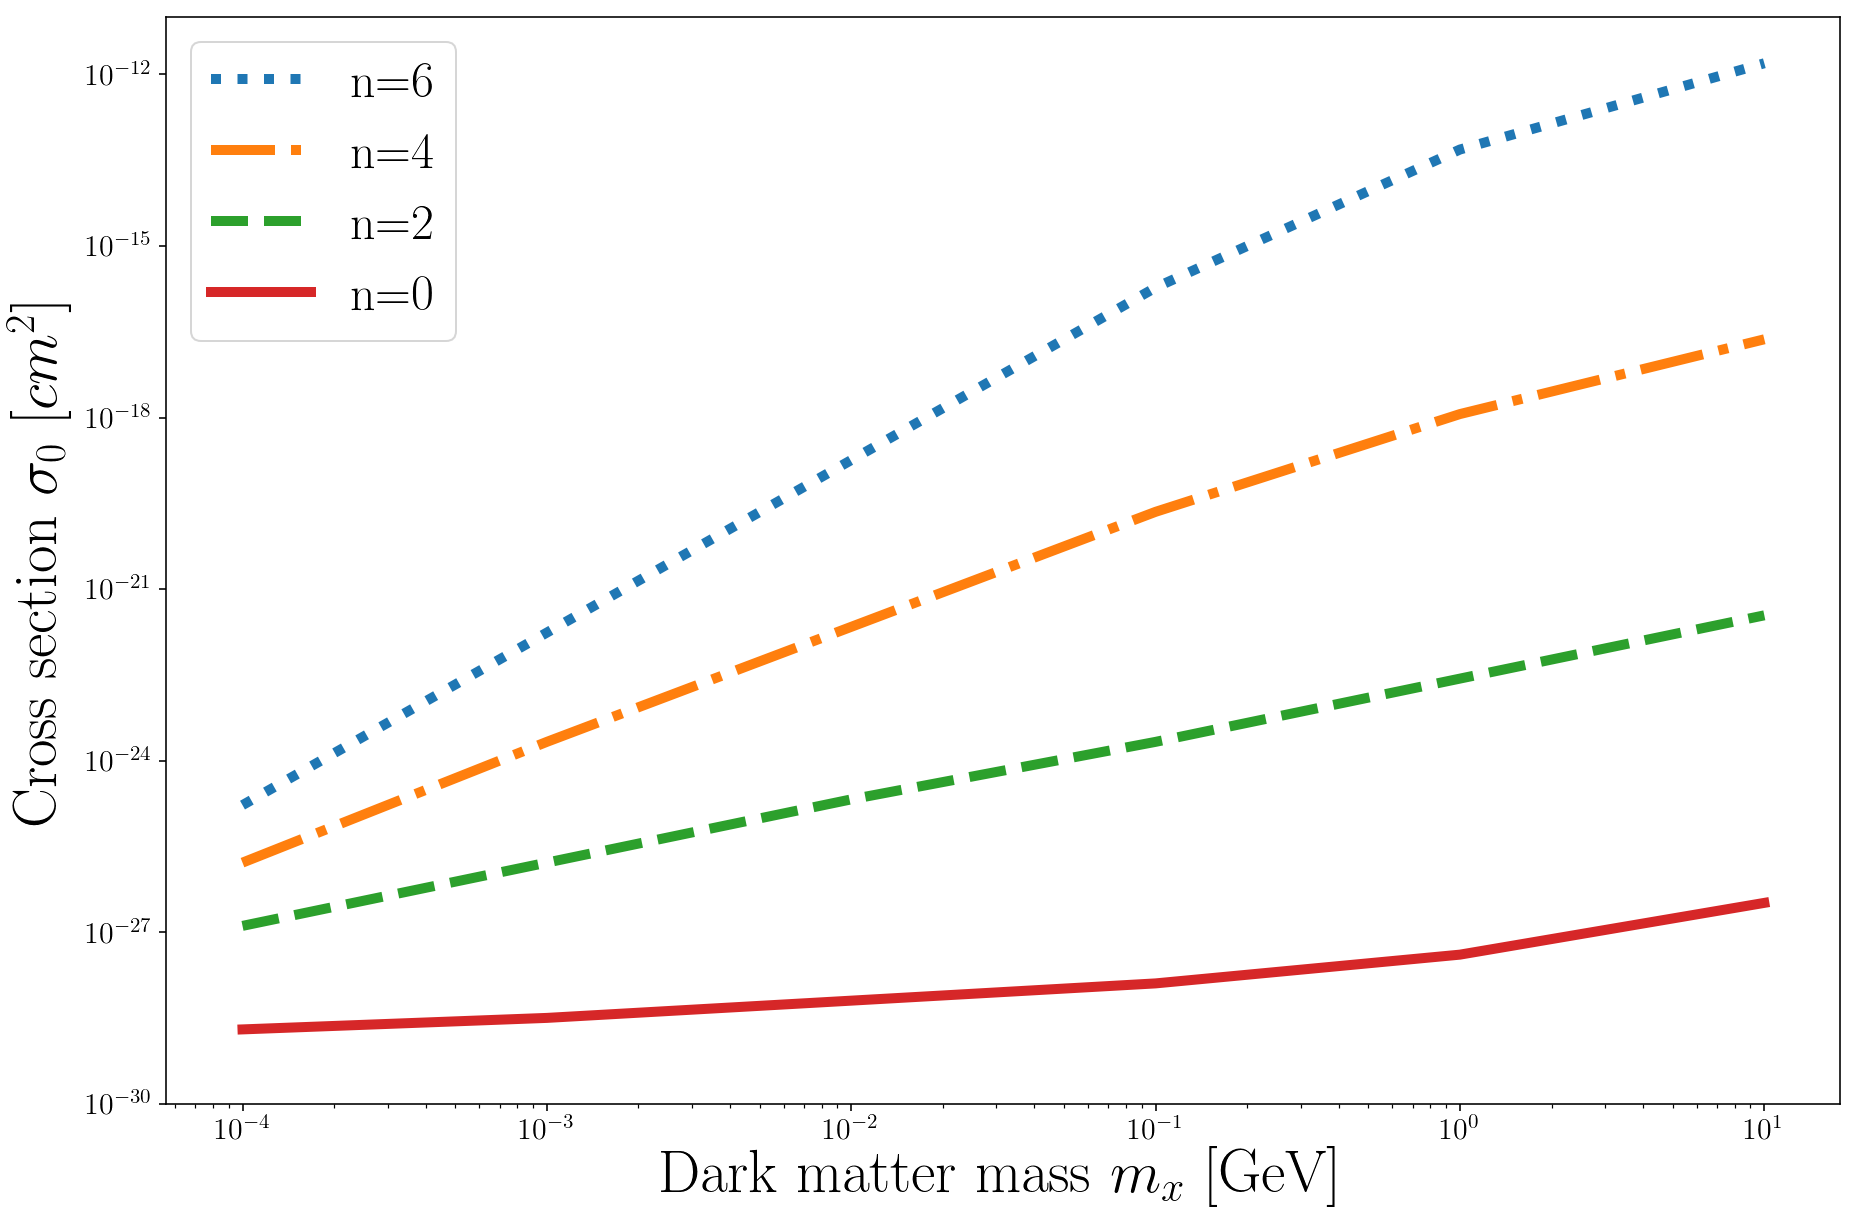

In [37]:
klim = vds0.mhm2khm(3*10**8)
# klim=0.1
plt.figure(figsize=(15,10))

plt.loglog(vds0.masses, vds0.sig(klim,6.), label="n=6",linewidth=5,linestyle=':')
plt.loglog(vds0.masses, vds0.sig(klim,4.), label="n=4",linewidth=5,linestyle='-.')
plt.loglog(vds0.masses, vds0.sig(klim,2.), label="n=2",linewidth=5,linestyle='--')
plt.loglog(vds0.masses, vds0.sig(klim,0.), label="n=0",linewidth=5)

# plt.title(r"Analytical", fontsize=20)
plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]", fontsize=30)
plt.xlabel(r"Dark matter mass $m_x$ [GeV]", fontsize=30)
plt.legend(fontsize=25)
plt.tick_params(labelsize=15)
plt.ylim(1e-30,1e-11)

# plt.savefig("analytical.png")

#### Limits by exclusion curve

In [38]:
sigs2cons = [3.5e-26,1.5e-23,9.8e-22]
sigs4cons = [4.6e-24,8.3e-19,1.45e-15]
sigs6cons = [3.1e-22,9.5e-13,1.6e-9]

sigs0_anal = [vds0.sig(klim,0.)[0],vds0.sig(klim,0.)[2],vds0.sig(klim,0.)[4]]
sigs2_anal = [vds0.sig(klim,2.)[0],vds0.sig(klim,2.)[2],vds0.sig(klim,2.)[4]]
sigs4_anal = [vds0.sig(klim,4.)[0],vds0.sig(klim,4.)[2],vds0.sig(klim,4.)[4]]
sigs6_anal = [vds0.sig(klim,6.)[0],vds0.sig(klim,6.)[2],vds0.sig(klim,6.)[4]]

sigs0_eft = [8.8e-27,2.6e-26,1.5e-25,1.4e-23]
sigs2_eft = [4.2e-23,4.3e-21,5.3e-18,2.2e-15]
sigs4_eft = [1.6e-20,1.0e-16,4.1e-11,9.3e-09]
sigs6_eft = [5.0e-04,1.5e+00]

mass = [0.0001,0.01,1]
mass_eft = [1.5e-5,0.001,1,1000]
mass_eft6 = [1,1000]

In [53]:
n2_limits = pd.DataFrame({'Mass (GeV)':mass,'$\sigma_0$ super conservative ($cm^2$)':sigs2cons,'$\sigma_0$ analytical ($cm^2$)':sigs2_anal})
n4_limits = pd.DataFrame({'Mass (GeV)':mass,'$\sigma_0$ super conservative ($cm^2$)':sigs4cons,'$\sigma_0$ analytical ($cm^2$)':sigs4_anal})
n6_limits = pd.DataFrame({'Mass (GeV)':mass,'$\sigma_0$ super conservative ($cm^2$)':sigs6cons,'$\sigma_0$ analytical ($cm^2$)':sigs6_anal})

3.1257158496882354e-21
1.7886495290574352e-25


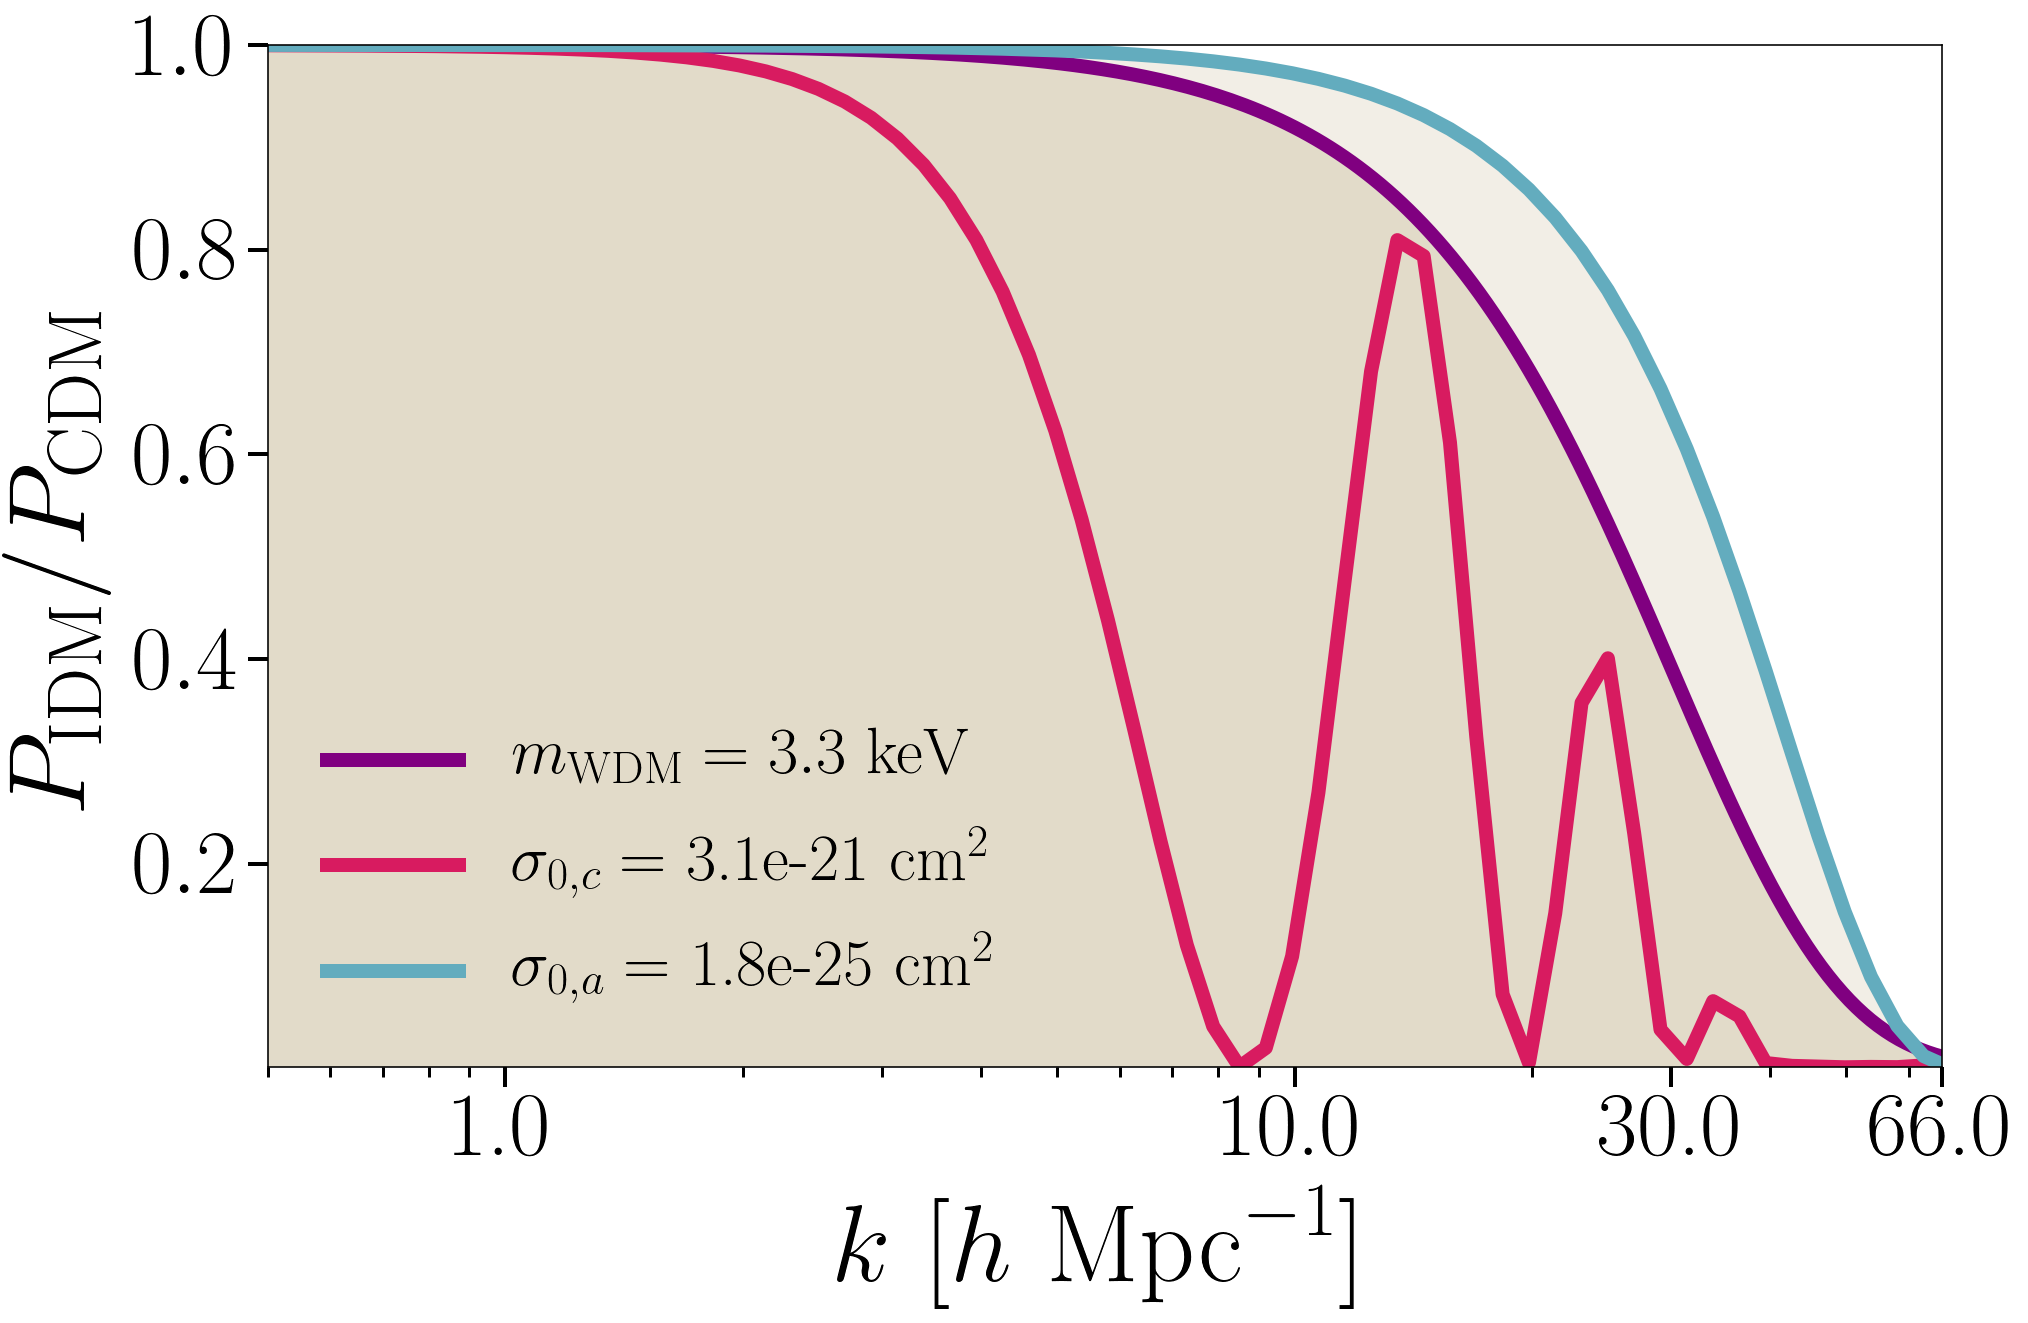

In [57]:
plt.figure(figsize=(15,10))

ks2 = np.logspace(-5,4,1000)
plt.semilogx(ks2,vds0.transfer(ks2,3.3)**2,linestyle='-',label=r'$m_{\rm{WDM}} = 3.3\ \rm{keV}$',c='#800080',lw=7)

# tk_idm,ks,sigma0 = vds0.single_tk(npow=2,m=0.0001,pltType='cons',sigmas=smallSigs,index=54,lw=7)
# tk_idm,ks,sigma0 = vds0.single_tk(npow=2,m=0.0001,pltType='analytic',sigmas=smallSigs,index=68,lw=7)
# tk_idm,ks,sigma0 = vds0.single_tk(npow=2,m=0.01,pltType='cons',sigmas=smallSigs,index=28,lw=7)
# tk_idm,ks,sigma0 = vds0.single_tk(npow=2,m=0.01,pltType='analytic',sigmas=smallSigs,index=45,lw=7)
# tk_idm,ks,sigma0 = vds0.single_tk(npow=2,m=1,pltType='cons',sigmas=smallSigs,index=10,lw=7)
# tk_idm,ks,sigma0 = vds0.single_tk(npow=2,m=1,pltType='analytic',sigmas=smallSigs,index=25,lw=7)

# tk_idm,ks,sigma0 = vds0.single_tk(npow=4,m=1,pltType='cons',sigmas=np.logspace(-10,-30,30),index=7,lw=7)
# tk_idm,ks,sigma0 = vds0.single_tk(npow=4,m=1,pltType='analytic',sigmas=smallSigs2,index=6,lw=7)
# tk_idm,ks,sigma0 = vds0.single_tk(npow=4,m=0.01,pltType='cons',sigmas=np.logspace(-10,-30,100),index=40,lw=7)
# tk_idm,ks,sigma0 = vds0.single_tk(npow=4,m=0.01,pltType='analytic',sigmas=smallSigs2,index=35,lw=7)
# tk_idm,ks,sigma0 = vds0.single_tk(npow=4,m=0.0001,pltType='cons',sigmas=smallSigs,index=33,lw=7)
# tk_idm,ks,sigma0 = vds0.single_tk(npow=4,m=0.0001,pltType='analytic',sigmas=smallSigs2,index=68,lw=7)

tk_idm,ks,sigma0 = vds0.single_tk(npow=6,m=1,pltType='cons',sigmas=np.logspace(-5,-30,100),index=15,lw=7)
# tk_idm,ks,sigma0 = vds0.single_tk(npow=6,m=1,pltType='analytic',sigmas=largeSigs,index=16,lw=7)
tk_idm,ks,sigma0 = vds0.single_tk(npow=6,m=0.01,pltType='cons',sigmas=largeSigs,index=10,lw=7)
# tk_idm,ks,sigma0 = vds0.single_tk(npow=6,m=0.01,pltType='analytic',sigmas=smallSigs2,index=13,lw=7)
tk_idm,ks,sigma0 = vds0.single_tk(npow=6,m=0.0001,pltType='cons',sigmas=np.logspace(-20,-30,100),index=5,lw=7)
# tk_idm,ks,sigma0 = vds0.single_tk(npow=6,m=0.0001,pltType='analytic',sigmas=smallSigs,index=47,lw=7)

# plt.fill_between(np.logspace(-5,4,1000), -10, vds0.transfer(ks2,3.3)**2,np.logspace(-5,4,1000) <=30,color='#ccbe9f',alpha=0.3)
plt.fill_between(np.logspace(-5,4,1000), -10, vds0.transfer(ks2,3.3)**2,color='#ccbe9f',alpha=0.40)
plt.fill_between(ks,tk_idm,0,color='#ccbe9f', alpha=0.25)

# plt.text(7.4,0.65,"Conservative",rotation=-72,fontsize=30,alpha=0.85)
# plt.text(21,0.65,"WDM",rotation=-64,fontsize=30,alpha=0.85)
# plt.text(41,0.75,"Analytic",rotation=-67,fontsize=30,alpha=0.85)

plt.xscale("log")
plt.xlim(0.5,66)
plt.ylim(0.001,1)
plt.ylabel(r'$P_{\rm{IDM}}/P_{\rm{CDM}}$',fontsize=55,labelpad=5)
plt.xlabel(r'$k$ [$h\ \rm{Mpc}^{-1}$]',fontsize=55,labelpad=5)
plt.tick_params(labelsize=45,length=10,width=2)
plt.tick_params(which='minor',length=5,width=1.5)
plt.xticks([1e0,1e1,3e1,6.6e1],[1e0,1e1,3e1,6.6e1])
# plt.yticks([0.05,0.25,0.5,0.75,1.0])
plt.legend(fontsize=33,framealpha=0)
plt.subplots_adjust(bottom=0.17)
# plt.savefig("plots/exclusions/exclusion_n4_m100keV.png")

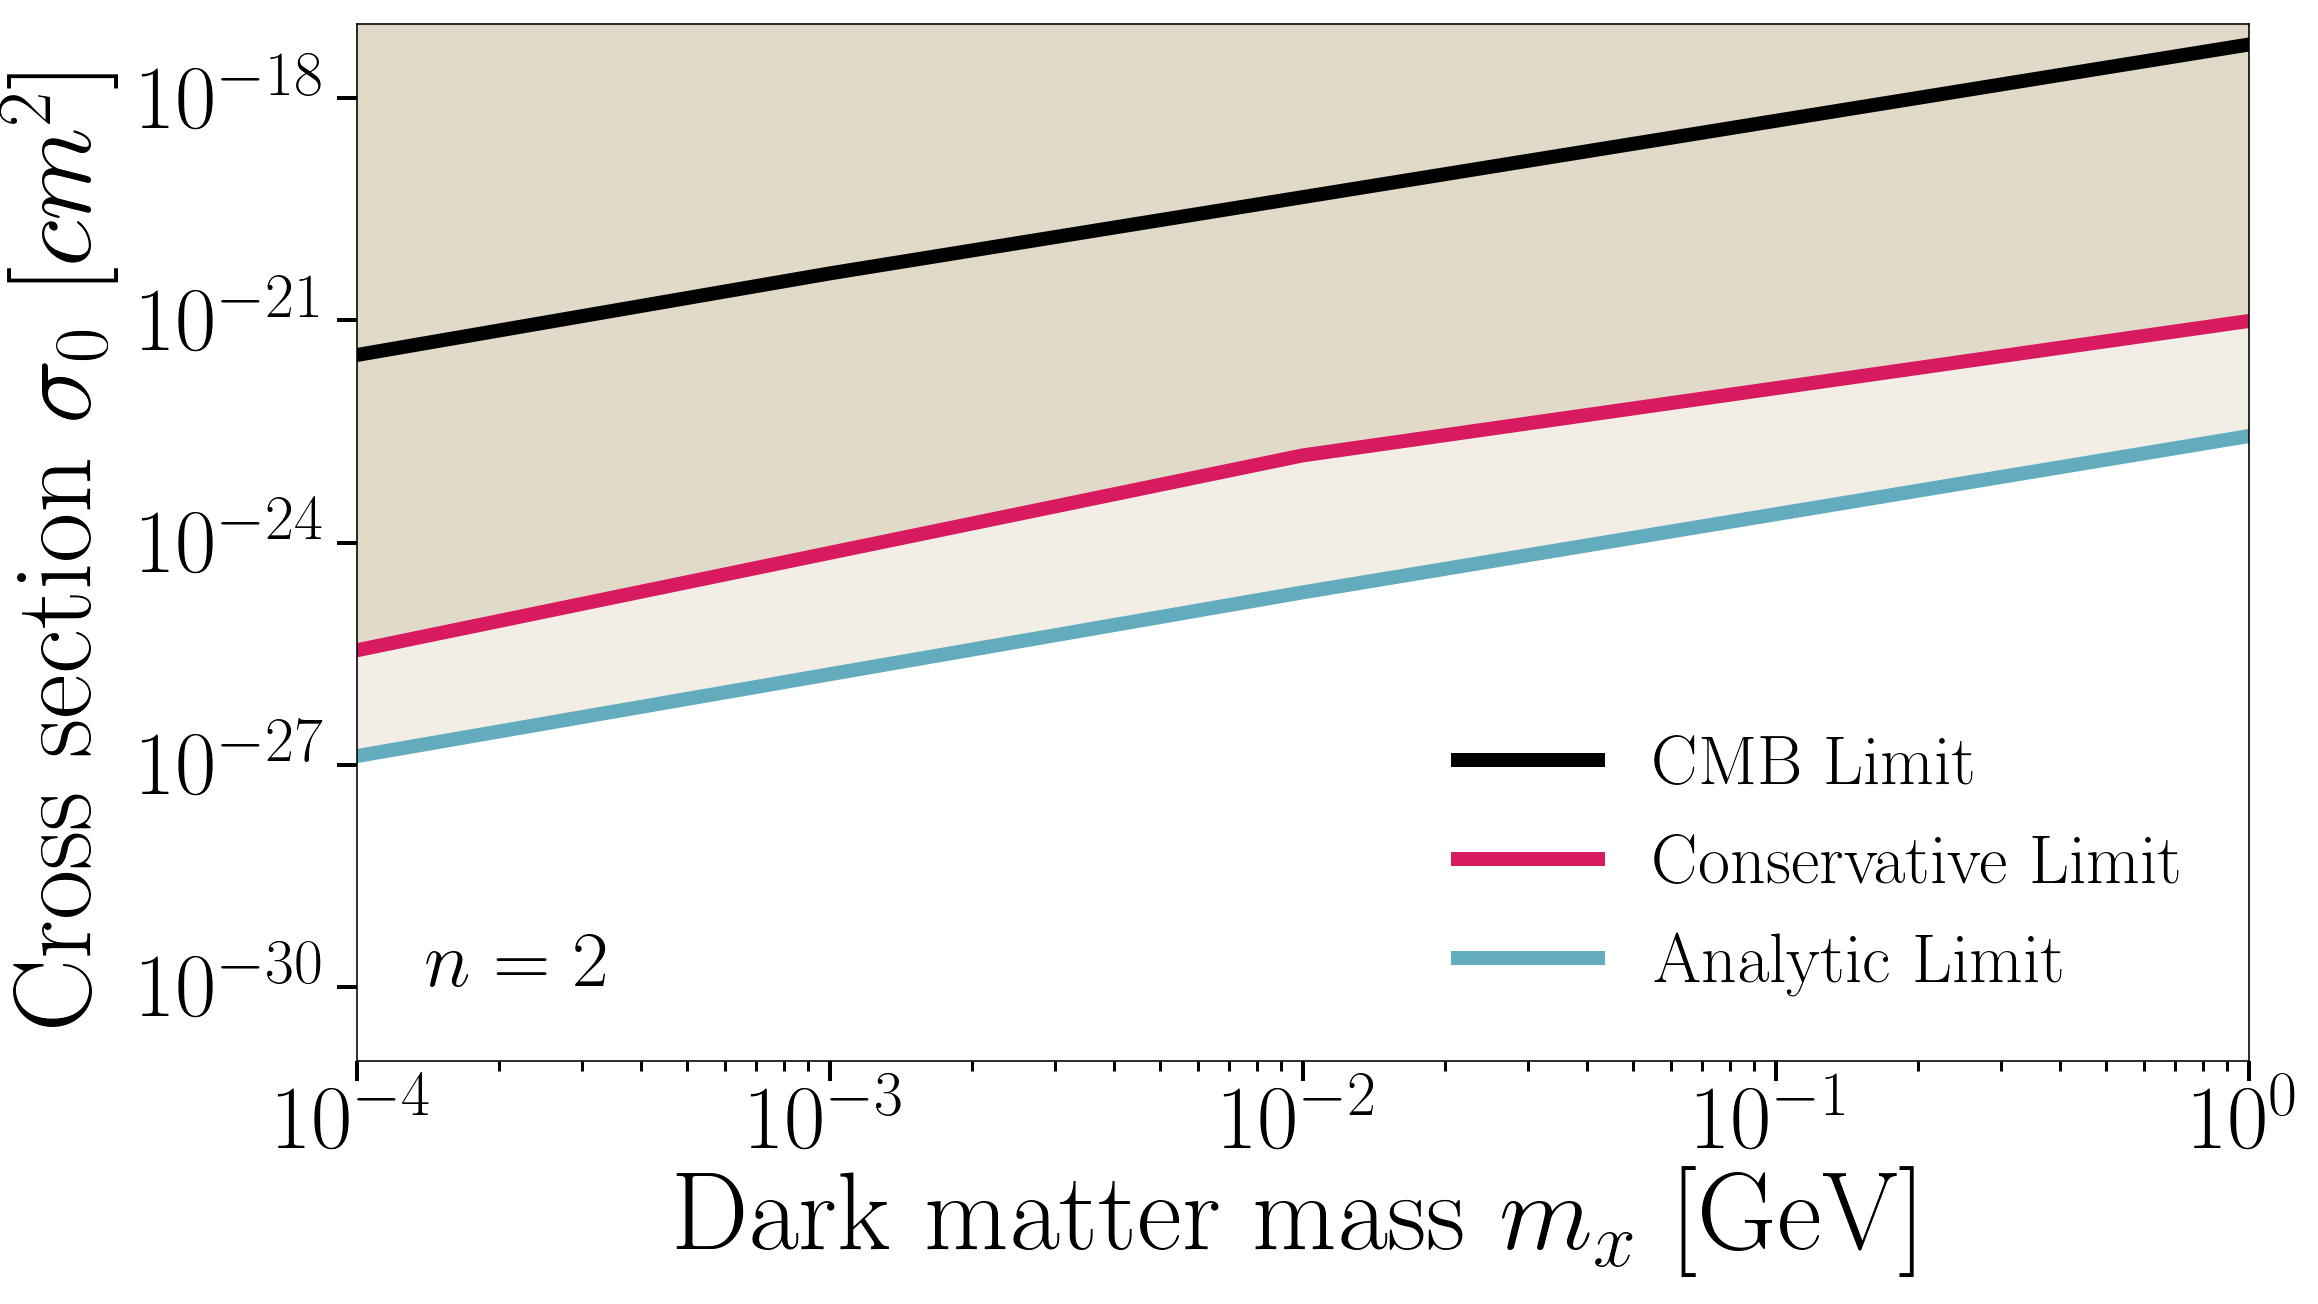

In [45]:
plt.figure(figsize=(18,10))

# plt.loglog(mass,sigs0_prog,label="n=0, progressive",linestyle='-',color='lightsteelblue',lw=3)
# plt.loglog(mass_eft,sigs0_eft,label="n=0, eft",linestyle='-',color='khaki',lw=3)

# plt.loglog(mass,sigs2_prog,label="n=2, Progressive",linestyle='-',color='lightsteelblue',lw=3)
# plt.text(1.6e-4,7e-24,"Excluded by\n Milky Way Satellites",fontsize=30,alpha=0.9)
plt.loglog(mass_eft,sigs2_eft,label="CMB Limit",linestyle='-',color='black',lw=7)
plt.loglog(mass,sigs2cons,label="Conservative Limit",linestyle='-',color='#D81B60',lw=7)
plt.loglog(mass, sigs2_anal, label="Analytic Limit",lw=7,linestyle='-',color='#63acbe')
plt.fill_between(mass, sigs2_anal, 1, color='#ccbe9f', alpha=0.25)
plt.fill_between(mass, sigs2cons, 1, color='#ccbe9f', alpha=0.4)
plt.text(1.4e-4,1e-30,"$n=2$",fontsize=40)
plt.yticks([1e-30,1e-27,1e-24,1e-21,1e-18],["$10^{-30}$","$10^{-27}$","$10^{-24}$","$10^{-21}$","$10^{-18}$"])
plt.ylim(1e-31,1e-17)

# plt.loglog(mass,sigs4_prog,label="n=4, Progressive",linestyle='-.',color='lightsteelblue',lw=3)
# plt.text(1.6e-4,1e-14,"Excluded by\n Milky Way Satellites",fontsize=30,alpha=0.9)
# plt.loglog(mass_eft,sigs4_eft,label="CMB Limit",linestyle='-',color='black',lw=7)
# plt.loglog(mass,sigs4cons,label="Conservative Limit",linestyle='-',color='#D81B60',lw=7)
# plt.loglog(mass, sigs4_anal, label="Analytic Limit",lw=7,linestyle='-',color='#63acbe')
# plt.fill_between(mass, sigs4_anal, 1, color='#ccbe9f', alpha=0.25)
# plt.fill_between(mass, sigs4cons, 1, color='#ccbe9f', alpha=0.4)
# plt.text(1.4e-4,1e-29,"$n=4$",fontsize=40)
# plt.yticks([1e-29,1e-26,1e-23,1e-20,1e-17],["$10^{-29}$","$10^{-26}$","$10^{-23}$","$10^{-20}$","$10^{-17}$"])
# plt.ylim(1e-31,1e-10)

# plt.loglog(mass,sigs6_prog,label="progressive",linestyle=':',color='lightsteelblue',lw=3)
# plt.text(1.6e-4,1e-13,"Excluded by\n Milky Way Satellites",fontsize=30,alpha=0.9)
# plt.loglog(mass_eft6,sigs6_eft,label="eft",linestyle='-',color='black',lw=7)
# plt.loglog(mass,sigs6cons,label="Conservative Limit",linestyle='-',color='#D81B60',lw=7)
# plt.loglog(mass, sigs6_anal, label="Analytic Limit",lw=7,linestyle='-',color='#63acbe')
# plt.fill_between(mass, sigs6_anal, 1, color='#ccbe9f', alpha=0.25)
# plt.fill_between(mass, sigs6cons, 1, color='#ccbe9f', alpha=0.4)
# plt.text(1.4e-4,1e-29,"$n=6$",fontsize=40)
# plt.yticks([1e-29,1e-26,1e-23,1e-20,1e-17,1e-14,1e-11,1e-8],["$10^{-29}$","$10^{-26}$","$10^{-23}$","$10^{-20}$","$10^{-17}$","$10^{-14}$","$10^{-11}$","$10^{-8}$"])
# plt.ylim(1e-31,1e-7)

plt.xlim(1e-4,1)
plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]",fontsize=55,labelpad=5)
plt.xlabel(r"Dark matter mass $m_x$ [GeV]",fontsize=55,labelpad=5)
plt.legend(fontsize=35,loc='lower right',framealpha=0)
plt.tick_params(labelsize=45,length=10,width=2)
plt.tick_params(which='minor',length=5,width=1.5)

plt.subplots_adjust(left=0.17,bottom=0.16)
plt.savefig("plots/limits/limits_n2_CAE.png")
# plt.savefig("plots/limits/limits_n4_CAE.png")
# plt.savefig("plots/limits/limits_n6_CAE.png")

---

---

---

# Transfer function business

3.944206059437648e-26
4.6415888336127916e-24
3.8535285937105196e-22


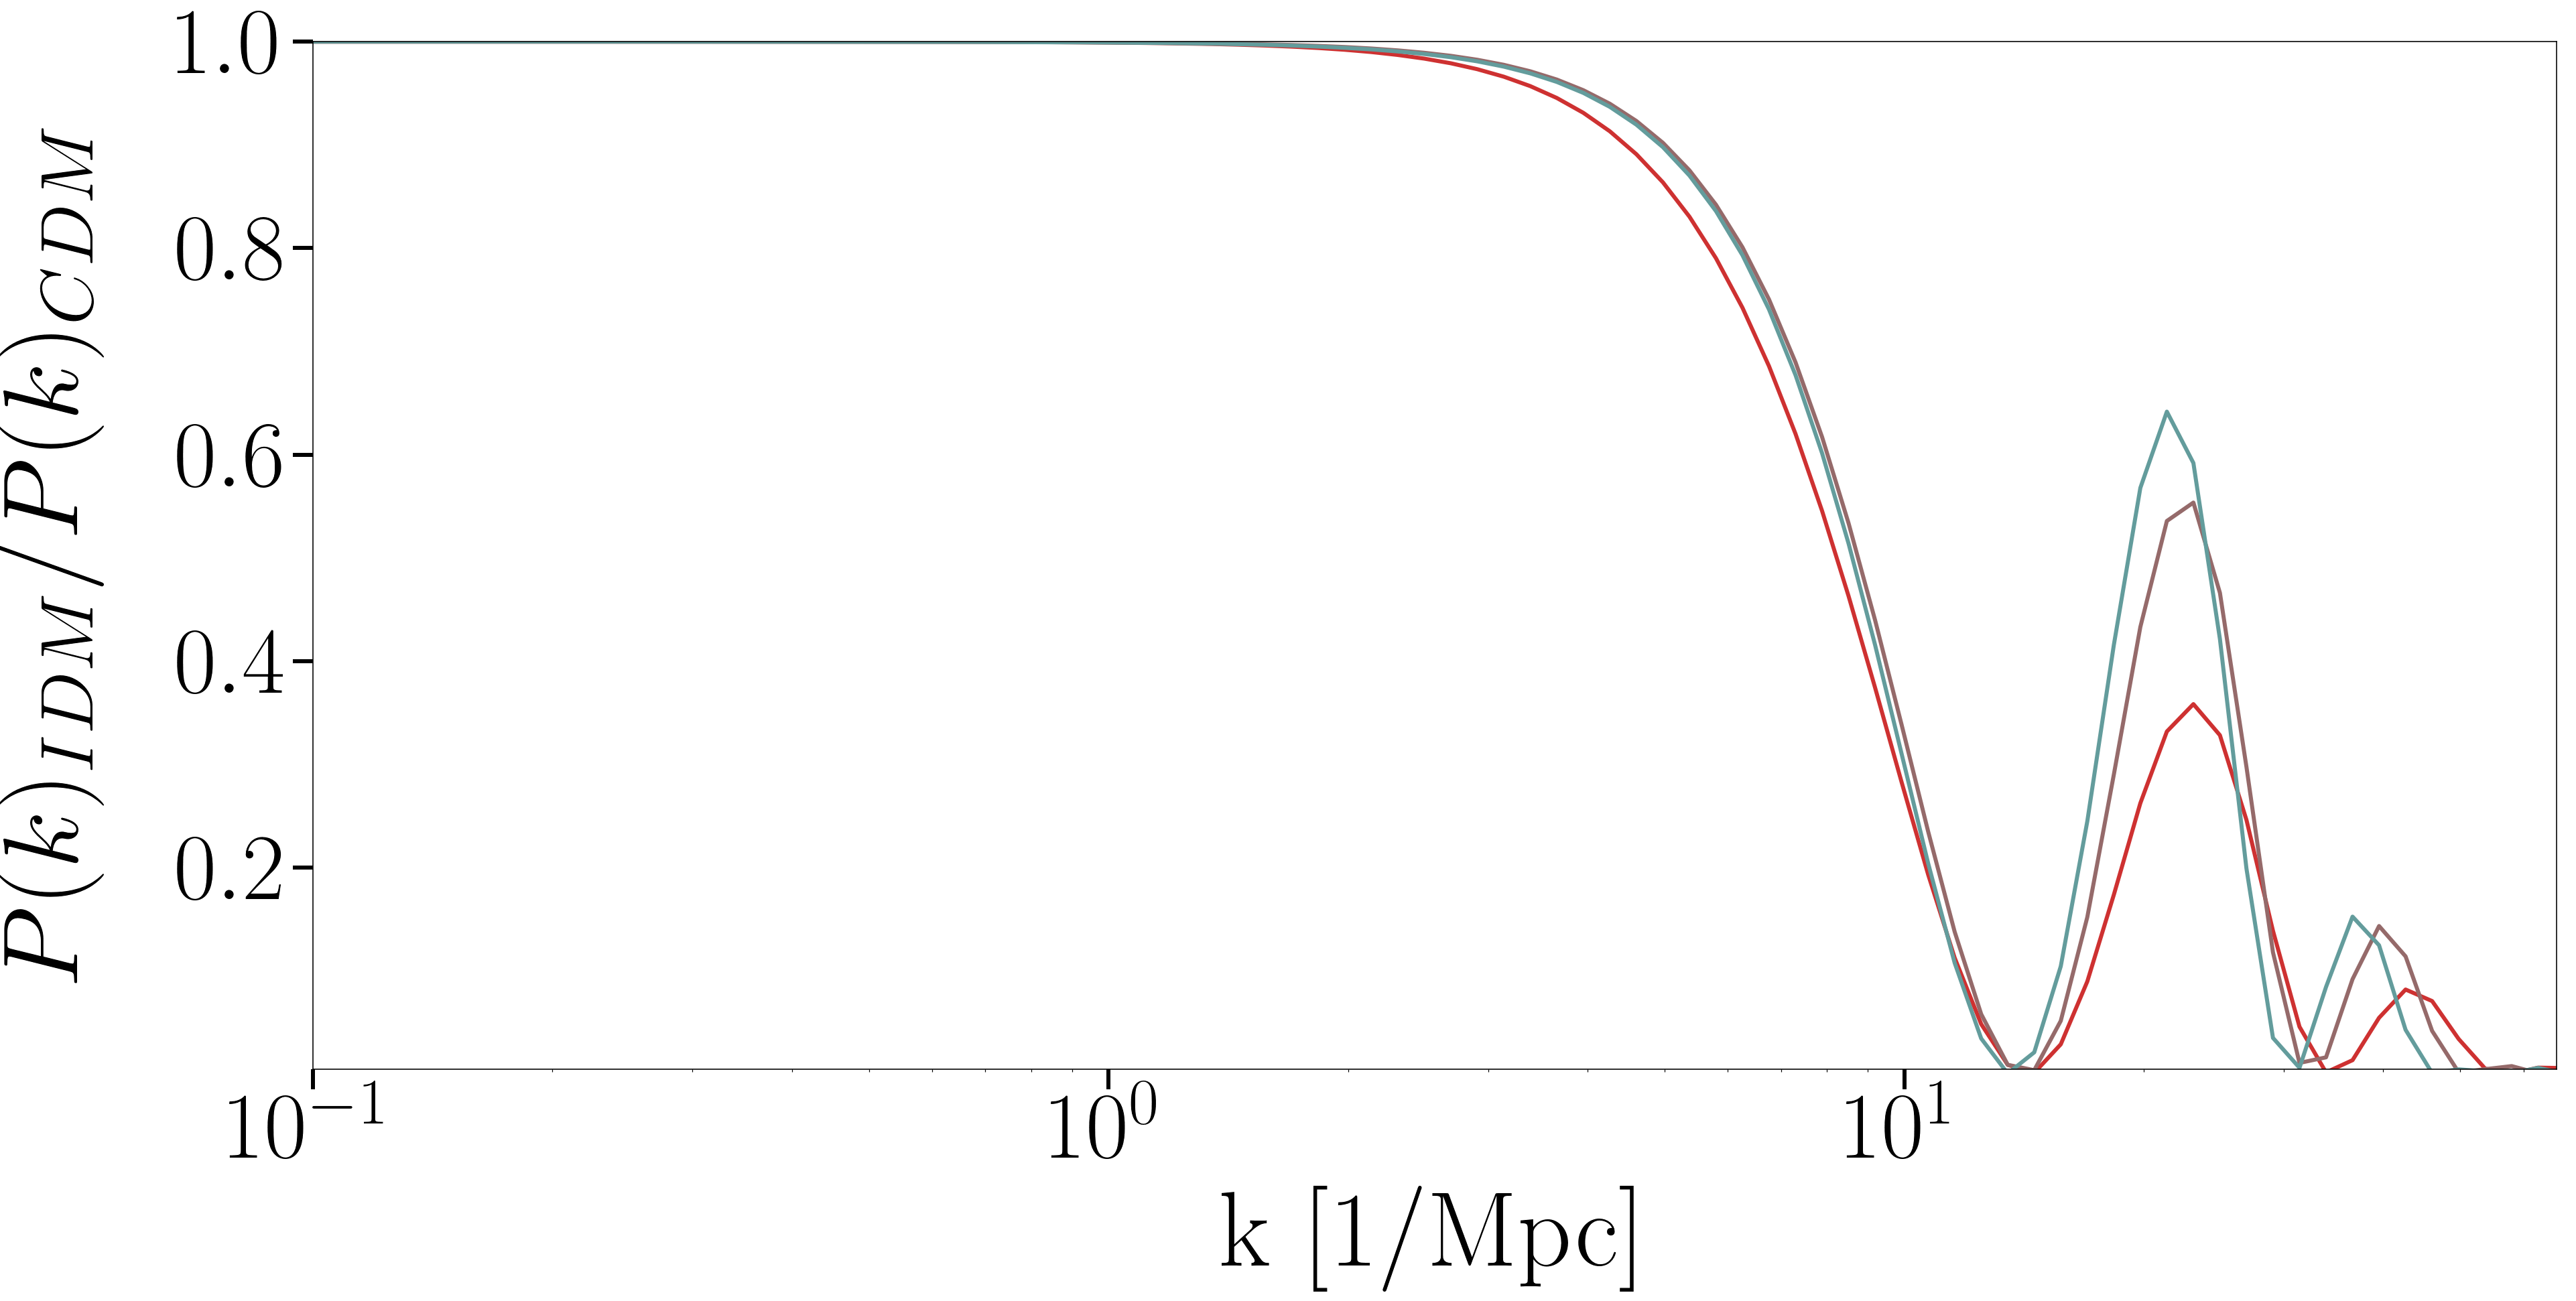

In [59]:
plt.figure(figsize=(30,15))    
plt.xscale('log')
plt.xlim(1e-1,66)
plt.ylim(0.005,1)
plt.ylabel(r"$P(k)_{IDM}/P(k)_{CDM}$", fontsize=80,labelpad=45)
plt.xlabel(r"k [1/Mpc]", fontsize=80)
plt.tick_params(labelsize=70,length=15,width=3)

# tks,ks,sgma = vds0.single_tk(colorbar=True,npow=0,label="n=0",sigmas=smallSigs,index=20,lw=3)
tks,ks,sgma = vds0.single_tk(npow=2,label="n=2",sigmas=smallSigs2,index=64,lw=3)
tks,ks,sgma = vds0.single_tk(npow=4,label="n=4",sigmas=smallSigs,index=33,lw=3)
tks,ks,sgma = vds0.single_tk(npow=6,label="n=6",sigmas=smallSigs,index=14,lw=3)

# plt.axvline(12,lw=10)

# plt.legend(fontsize=58)

plt.subplots_adjust(bottom=0.17)
# plt.savefig("plots/tk/tk_all_n2.png",dpi=200)

(0.1, 66)

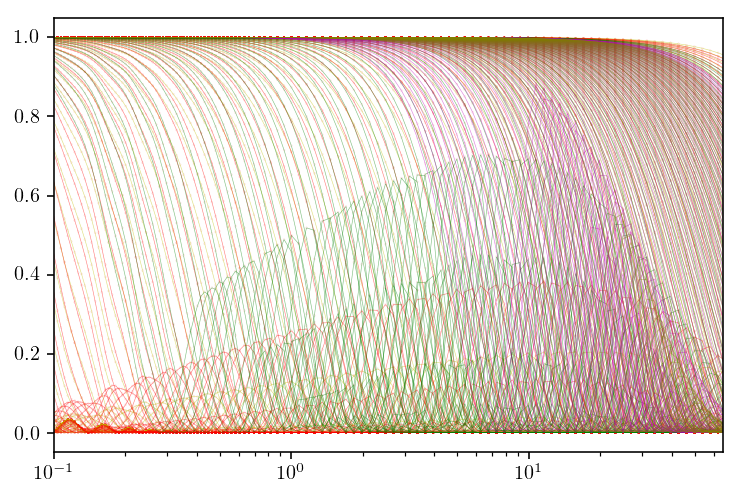

In [60]:
vds0.all_tk(npow=1,m=0.0001,sigmas=smallSigs2)
vds0.all_tk(npow=2,m=0.0001,sigmas=smallSigs2)
vds0.all_tk(npow=3,m=0.0001,sigmas=smallSigs2)
vds0.all_tk(npow=4,m=0.0001,sigmas=smallSigs2)
vds0.all_tk(npow=5,m=0.0001,sigmas=smallSigs2)
vds0.all_tk(npow=6,m=0.0001,sigmas=smallSigs)
vds0.all_tk(npow=8,m=0.0001,sigmas=smallSigs)
vds0.all_tk(npow=10,m=0.0001,sigmas=smallSigs)

plt.xlim(1e-1,66)

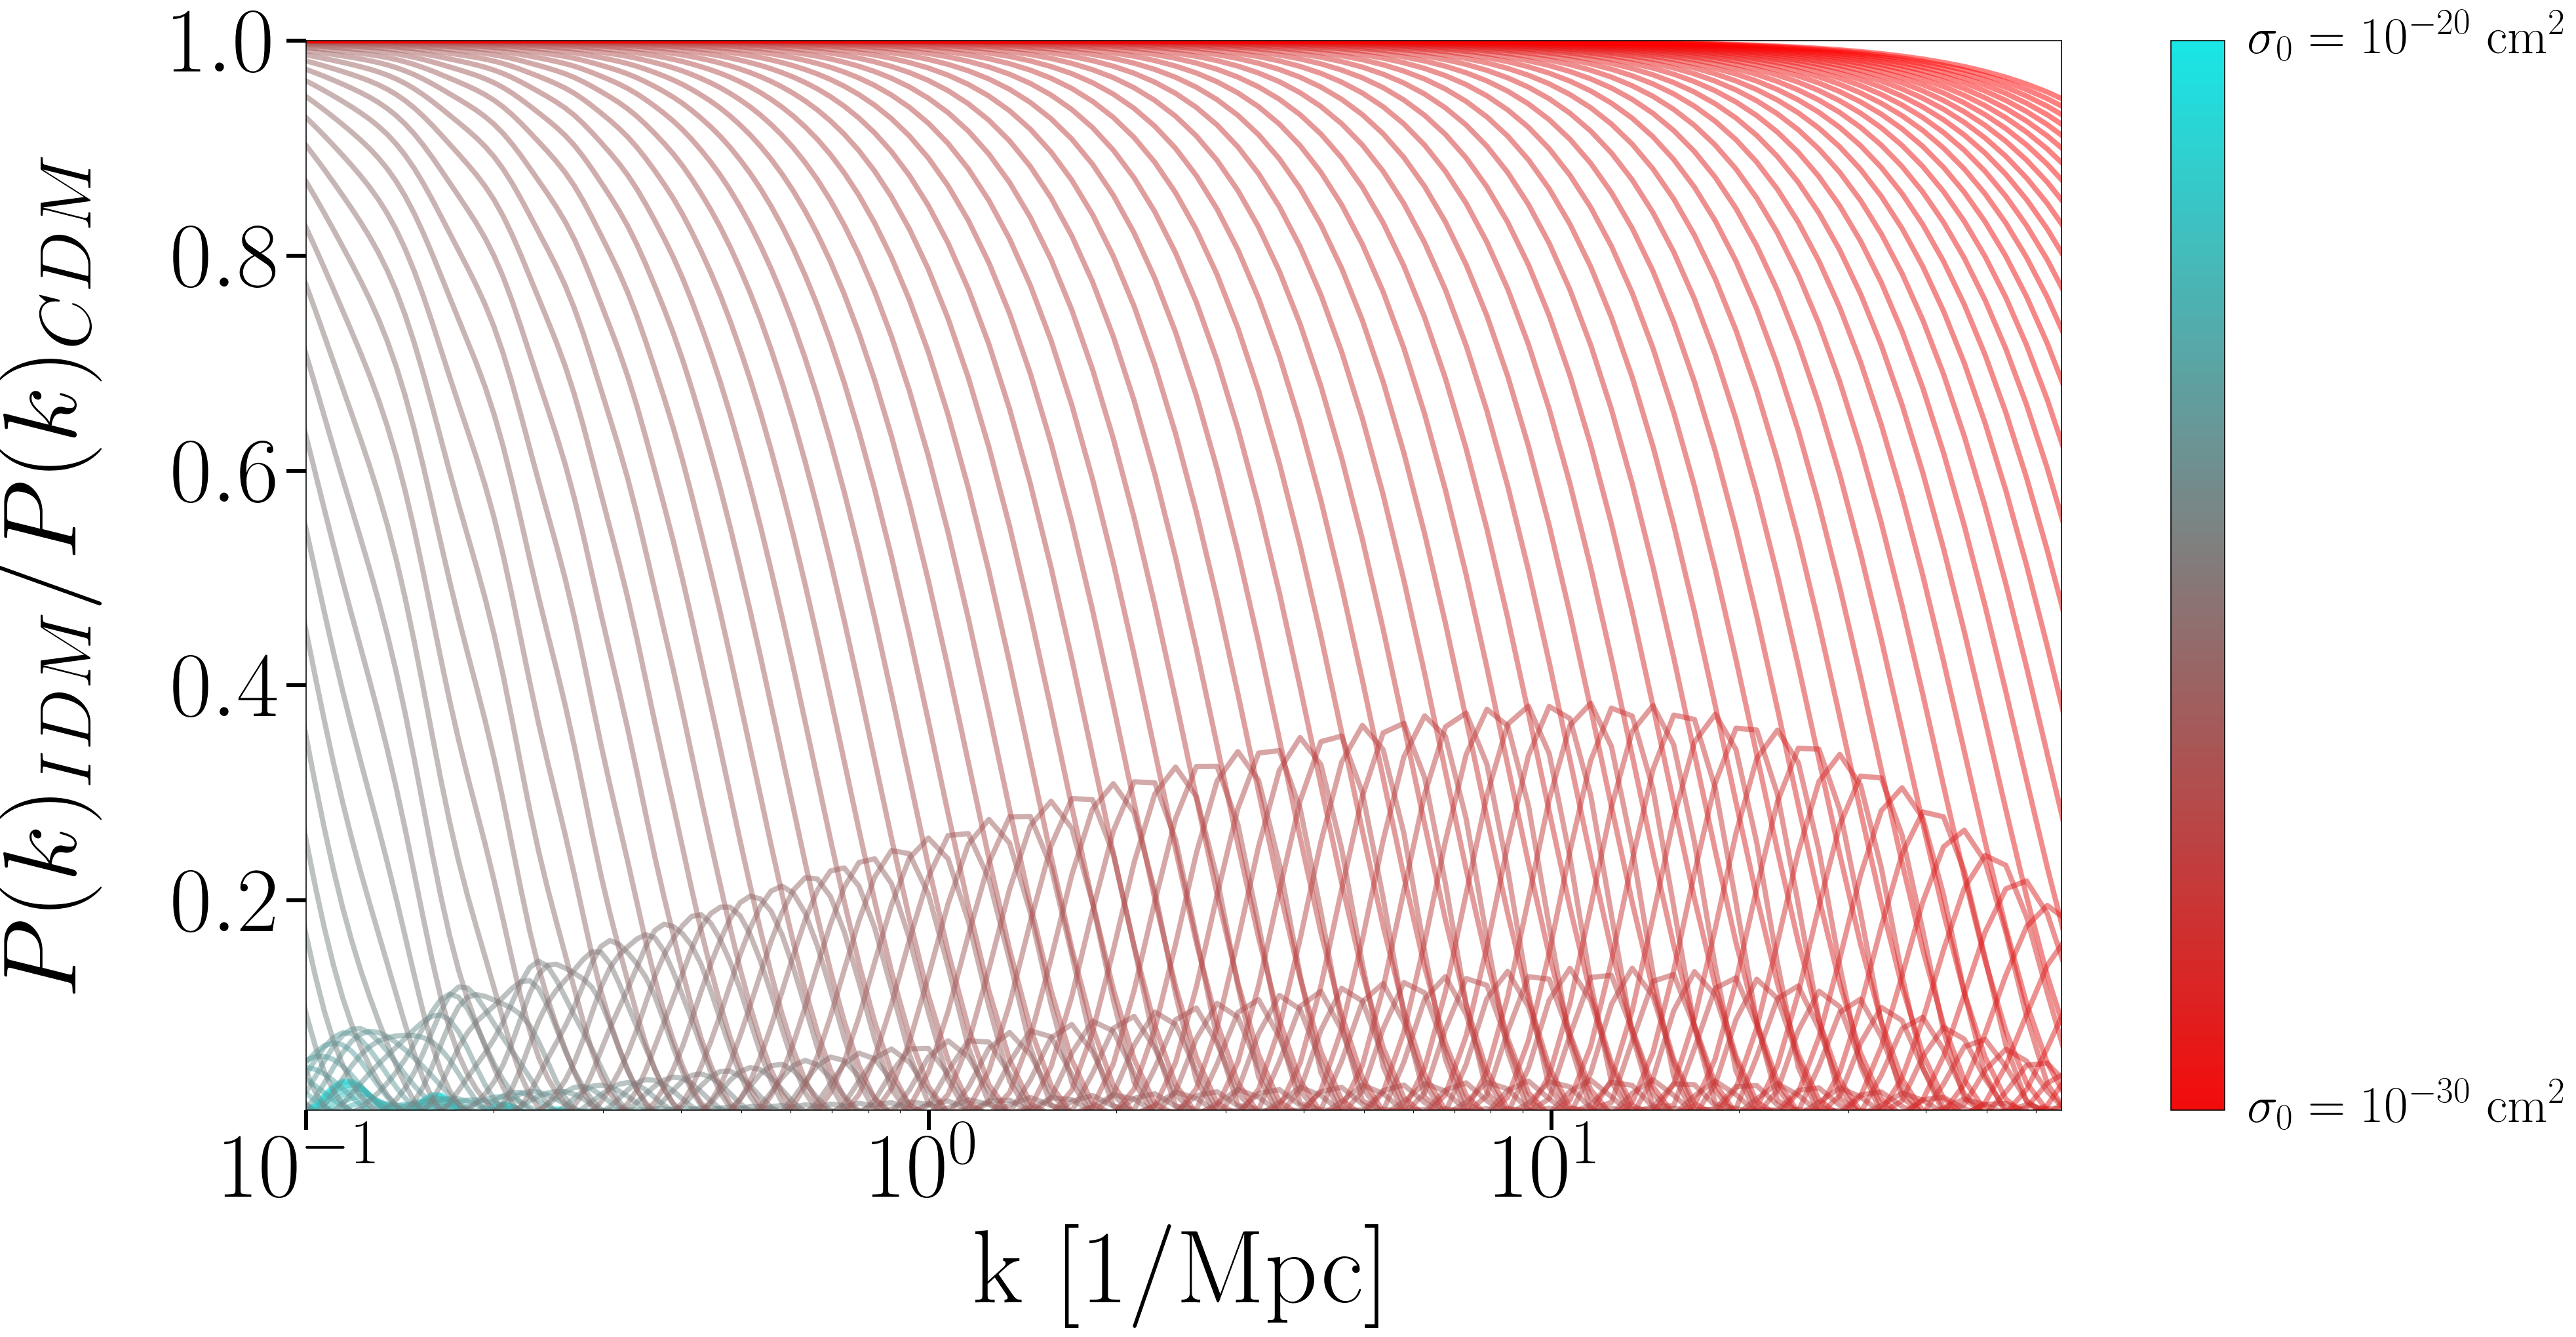

In [50]:
plt.figure(figsize=(30,15))    
plt.xscale('log')
plt.xlim(1e-1,66)
plt.ylim(0.005,1)
plt.ylabel(r"$P(k)_{IDM}/P(k)_{CDM}$", fontsize=80,labelpad=45)
plt.xlabel(r"k [1/Mpc]", fontsize=80)
plt.tick_params(labelsize=70,length=15,width=3)

vds0.all_tk(colorbar=True,npow=2,m=0.0001,sigmas=smallSigs2,lw=4)

In [100]:
# k1,tk1,s1 = vds0.peaks(npow=1)
k2,tk2,s2 = vds0.peaks(npow=2)
# k3,tk3,s3 = vds0.peaks(npow=3)
# k4,tk4,s4 = vds0.peaks(npow=4)
# k5,tk5,s5 = vds0.peaks(npow=5)
# k6,tk6,s6 = vds0.peaks(npow=6,sigmas=smallSigs)
# k8,tk8,s8 = vds0.peaks(npow=8,sigmas=smallSigs)
# k10,tk10,s10 = vds0.peaks(npow=10,sigmas=smallSigs)

#### Fitting business

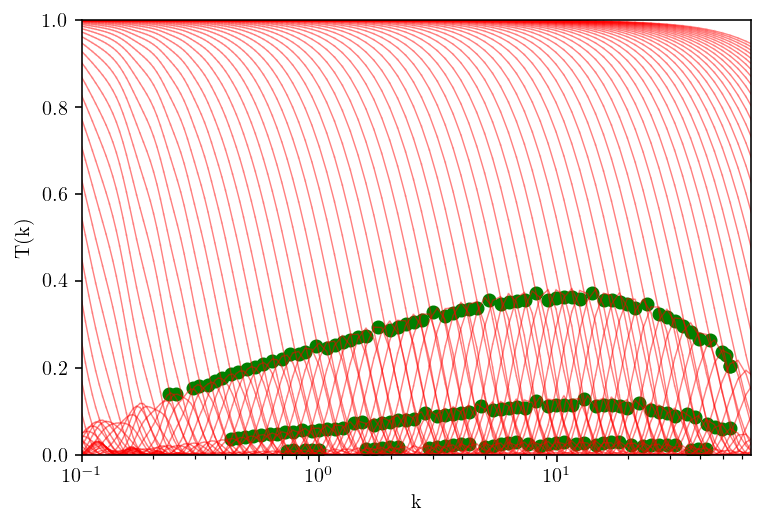

In [120]:
for i in range(len(tk2)):
    for j in range(len(tk2[i])):
        try: plt.scatter(k2[i][j],tk2[i][j],c='g')
        except: continue

plt.scatter(k2[0][0],tk2[0][0],c='g',label='n=2')
# plt.xscale('log')
plt.xlim(1e-1,66)
plt.ylim(0,1)
plt.xlabel("k")
plt.ylabel("T(k)")
# plt.legend()
vds0.all_tk(npow=2,m=0.0001,sigmas=smallSigs2,lw=0.7)

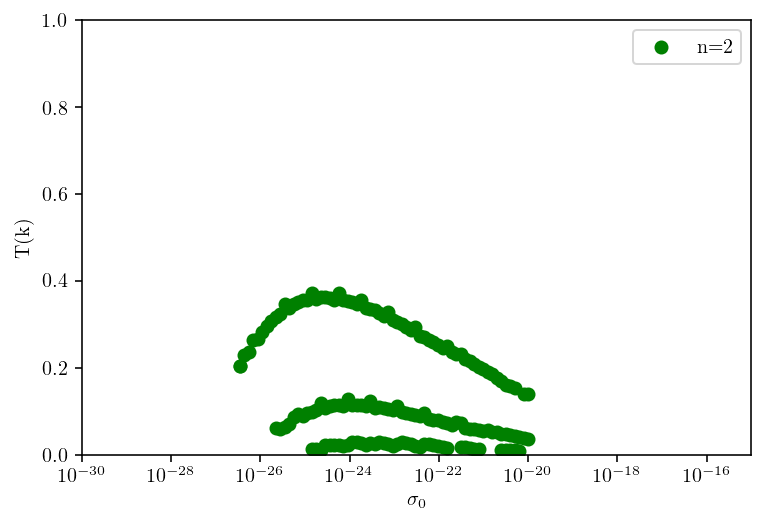

In [116]:
for i in range(len(tk2)):
    for j in range(len(tk2[i])):
        try: plt.scatter(s2[i],tk2[i][j],c='g')
        except: continue
plt.scatter(s2[0],tk2[0][0],c='g',label='n=2')
plt.xscale('log')
plt.xlim(1e-30,1e-15)
plt.ylim(0,1)
plt.xlabel("$\sigma_0$")
plt.ylabel("T(k)")
plt.legend()